Import libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import re
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import MultiLabelBinarizer
from mlxtend.frequent_patterns import fpgrowth


In [3]:
# load dataset
df = pd.read_csv(r"C:\Users\noufi\Downloads\drugs_side_effects_drugs_com.csv")
df.head()

,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,alcohol,related_drugs,medical_condition_description,rating,no_of_reviews,drug_link,medical_condition_url
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",87%,Rx,D,N,X,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0,https://www.drugs.com/doxycycline.html,https://www.drugs.com/condition/acne.html
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,spironolactone,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",82%,Rx,C,N,X,amlodipine: https://www.drugs.com/amlodipine.h...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.2,449.0,https://www.drugs.com/spironolactone.html,https://www.drugs.com/condition/acne.html
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",minocycline,Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",48%,Rx,D,N,NaN,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,5.7,482.0,https://www.drugs.com/minocycline.html,https://www.drugs.com/condition/acne.html
3,Accutane,Acne,problems with your vision or hearing; muscle o...,isotretinoin (oral),"Miscellaneous antineoplastics, Miscellaneous u...",NaN,41%,Rx,X,N,X,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.9,623.0,https://www.drugs.com/accutane.html,https://www.drugs.com/condition/acne.html
4,clindamycin,Acne,hives ; difficult breathing; swelling of your ...,clindamycin topical,"Topical acne agents, Vaginal anti-infectives","Cleocin T, Clindacin ETZ, Clindacin P, Clindag...",39%,Rx,B,N,NaN,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.4,146.0,https://www.drugs.com/mtm/clindamycin-topical....,https://www.drugs.com/condition/acne.html


In [4]:
df.shape

(2931, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931 entries, 0 to 2930
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   drug_name                      2931 non-null   object 
 1   medical_condition              2931 non-null   object 
 2   side_effects                   2807 non-null   object 
 3   generic_name                   2888 non-null   object 
 4   drug_classes                   2849 non-null   object 
 5   brand_names                    1718 non-null   object 
 6   activity                       2931 non-null   object 
 7   rx_otc                         2930 non-null   object 
 8   pregnancy_category             2702 non-null   object 
 9   csa                            2931 non-null   object 
 10  alcohol                        1377 non-null   object 
 11  related_drugs                  1462 non-null   object 
 12  medical_condition_description  2931 non-null   o

In [6]:
print(df.isnull().sum())

drug_name                           0
medical_condition                   0
side_effects                      124
generic_name                       43
drug_classes                       82
brand_names                      1213
activity                            0
rx_otc                              1
pregnancy_category                229
csa                                 0
alcohol                          1554
related_drugs                    1469
medical_condition_description       0
rating                           1345
no_of_reviews                    1345
drug_link                           0
medical_condition_url               0
dtype: int64


Data Cleaning

In [7]:
# removing unnecessary columns
df.drop(columns='brand_names', inplace=True)
df.shape

(2931, 16)

In [8]:
# fill missing categorical values with unknown
categorical_cols = ['side_effects', 'related_drugs', 'generic_name', 'drug_classes', 'rx_otc', 'pregnancy_category']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

In [9]:
# fill missing numerical values with 0
numeric_cols = ['rating', 'no_of_reviews']
for col in numeric_cols:
    df[col] = df[col].fillna(0)

In [10]:
#format columns
df['activity'] = df['activity'].astype(str).str.replace(r'\s+', '', regex=True).str.rstrip('%').astype('float') / 100
df['alcohol'] = df['alcohol'].replace(np.nan, 0).replace({'X': 1})

C:\Users\noufi\AppData\Local\Temp\ipykernel_30148\2787967852.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['alcohol'] = df['alcohol'].replace(np.nan, 0).replace({'X': 1})


Encode categorical variables

In [11]:
label_encoder = LabelEncoder()
encode_cols = [ 'rx_otc', 'generic_name', 'medical_condition', 'pregnancy_category', 'side_effects', 'csa',]
for col in encode_cols:
    df[col] = label_encoder.fit_transform(df[col])

Standardize numeric features

In [12]:
numeric_features = ['generic_name', 'medical_condition', 'no_of_reviews',
                'side_effects', 'rating', 'csa', 'pregnancy_category',
                'rx_otc', 'alcohol']
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

Exploratory Data Analysis (EDA)

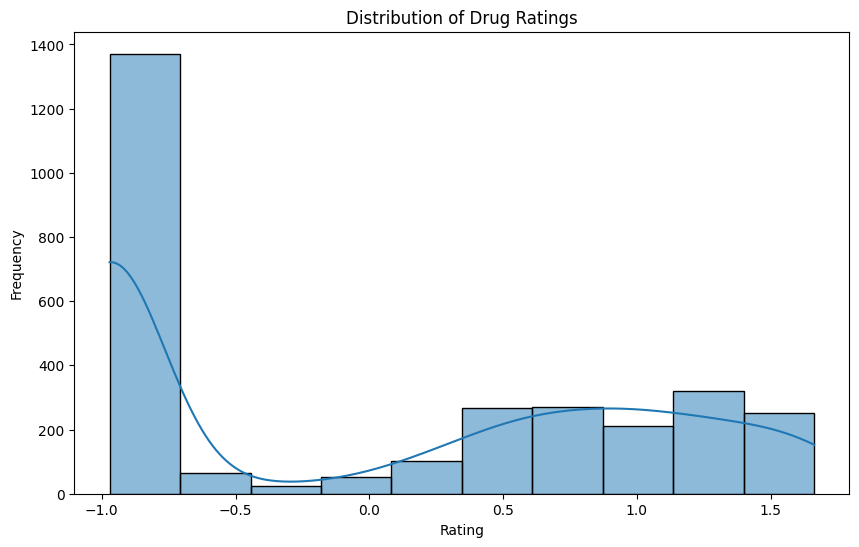

In [13]:
#Distribution of drug ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=10, kde=True)
plt.title('Distribution of Drug Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

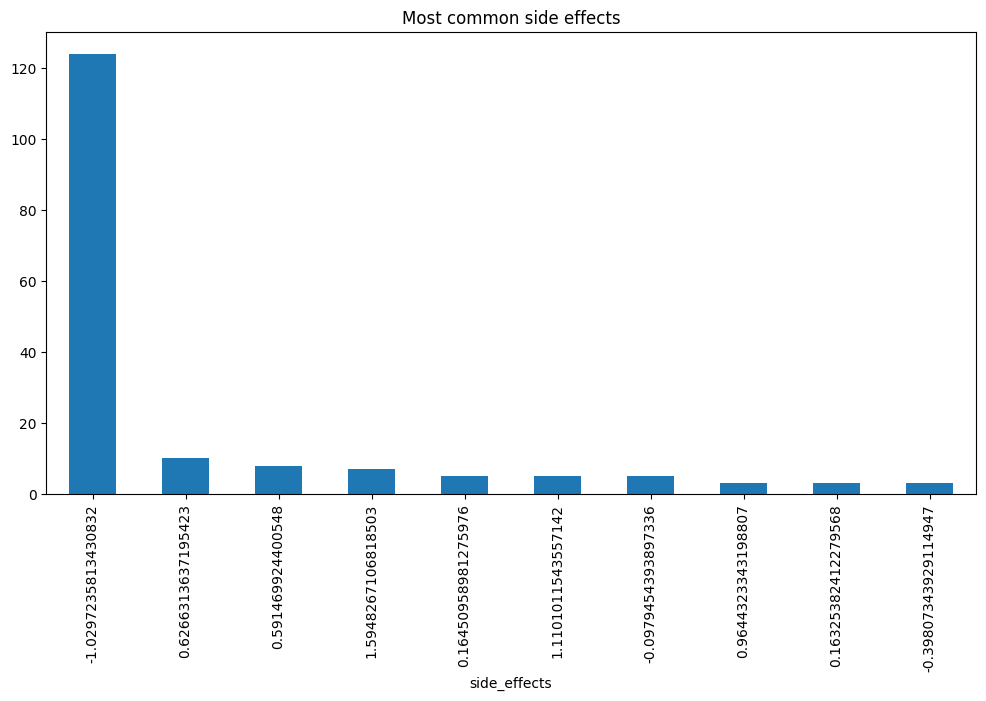

In [14]:
#analyzing the most common side effects
side_effects = df['side_effects'].value_counts().head(10).plot(kind='bar', figsize=(12,6))
#print(side_effects)
plt.title("Most common side effects")
plt.show()


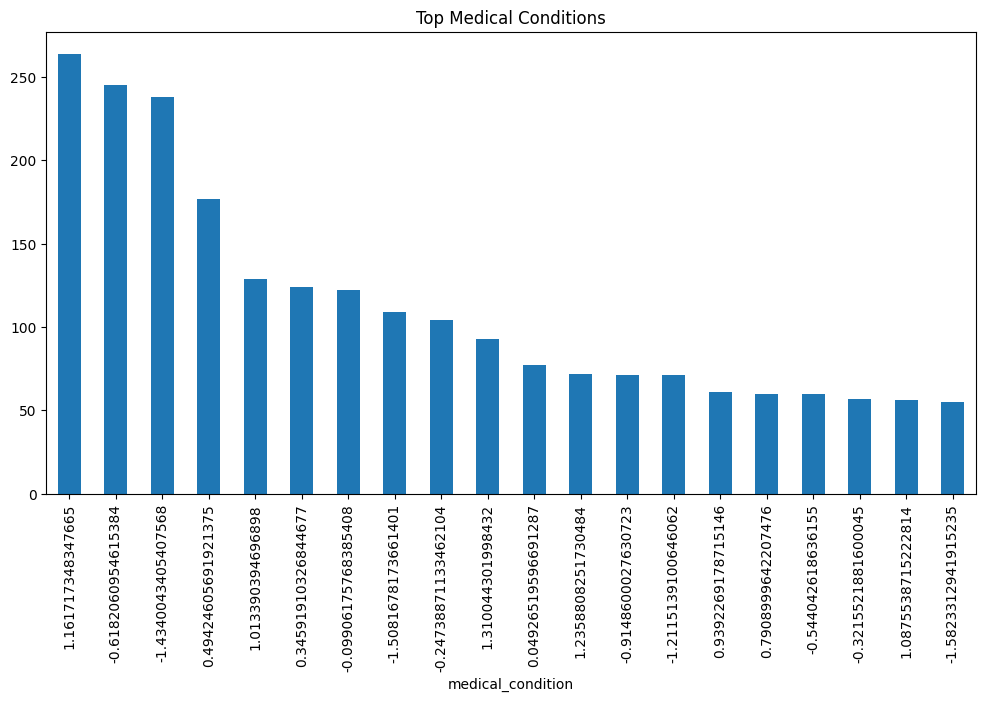

In [15]:
# top medical conditions
condition_counts = df['medical_condition'].value_counts().head(20).plot(kind='bar', figsize=(12,6))
plt.title("Top Medical Conditions")
plt.show()


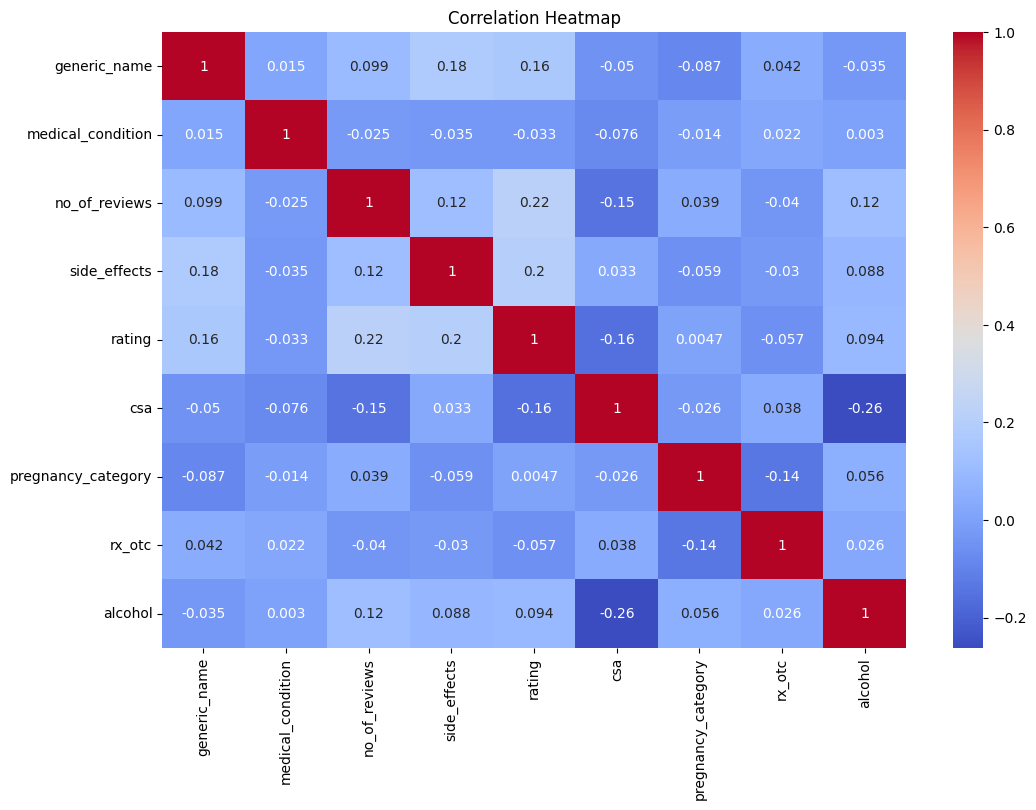

In [16]:
#corelation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [17]:
#creating boolean columns indicates whether a specific side effects appears in each row
df['Hives'] = df['side_effects'].astype(str).str.contains('hives', case=False)
df['Difficult Breathing'] = df['side_effects'].astype(str).str.contains('difficult breathing|difficulty breathing', case=False)


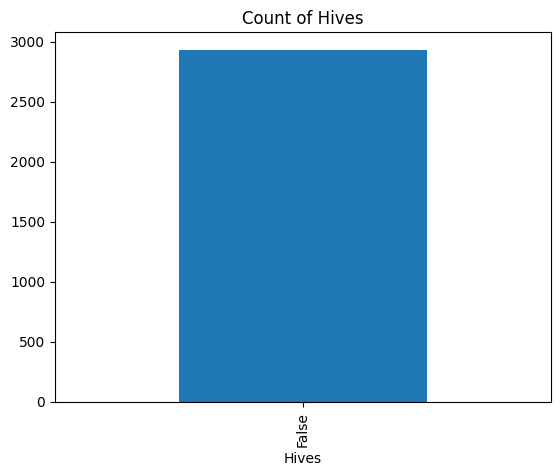

In [18]:
df['Hives'].value_counts().plot(kind='bar', title='Count of Hives')
plt.show()



In [19]:
df.to_csv("drugs_side_effects_cleaned.csv", index=False)
df.shape



(2931, 18)

In [20]:
df = pd.read_csv(r"C:\Users\noufi\Downloads\drugs_side_effects_drugs_com.csv")
df.head()

,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,alcohol,related_drugs,medical_condition_description,rating,no_of_reviews,drug_link,medical_condition_url
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",87%,Rx,D,N,X,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0,https://www.drugs.com/doxycycline.html,https://www.drugs.com/condition/acne.html
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,spironolactone,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",82%,Rx,C,N,X,amlodipine: https://www.drugs.com/amlodipine.h...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.2,449.0,https://www.drugs.com/spironolactone.html,https://www.drugs.com/condition/acne.html
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",minocycline,Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",48%,Rx,D,N,NaN,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,5.7,482.0,https://www.drugs.com/minocycline.html,https://www.drugs.com/condition/acne.html
3,Accutane,Acne,problems with your vision or hearing; muscle o...,isotretinoin (oral),"Miscellaneous antineoplastics, Miscellaneous u...",NaN,41%,Rx,X,N,X,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.9,623.0,https://www.drugs.com/accutane.html,https://www.drugs.com/condition/acne.html
4,clindamycin,Acne,hives ; difficult breathing; swelling of your ...,clindamycin topical,"Topical acne agents, Vaginal anti-infectives","Cleocin T, Clindacin ETZ, Clindacin P, Clindag...",39%,Rx,B,N,NaN,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.4,146.0,https://www.drugs.com/mtm/clindamycin-topical....,https://www.drugs.com/condition/acne.html


In [21]:
#Medical condition counts
medical_condition_counts = df['medical_condition'].value_counts()
print("Medical condition occurrence and frequency:")
print(medical_condition_counts)
medical_condition_counts.to_csv('medical_condition_counts.csv')

Medical condition occurrence and frequency:
medical_condition
Pain                    264
Colds & Flu             245
Acne                    238
Hypertension            177
Osteoarthritis          129
Hayfever                124
Eczema                  122
AIDS/HIV                109
Diabetes (Type 2)       104
Psoriasis                93
GERD (Heartburn)         77
Pneumonia                72
Bronchitis               71
Angina                   71
Migraine                 61
Insomnia                 60
Constipation             60
Diabetes (Type 1)        57
Osteoporosis             56
ADHD                     55
Depression               51
Seizures                 50
Bipolar Disorder         47
UTI                      46
Asthma                   45
Cholesterol              45
Anxiety                  45
Diarrhea                 38
Covid 19                 34
Rheumatoid Arthritis     33
Alzheimer's              27
COPD                     23
Weight Loss              23
IBD (Bowel)   

In [22]:
#extract side effects
def extract_side_effects(text):
    text = str(text) if pd.notna(text) else ""
    return [effect.strip() for effect in re.split(r';', text) if effect.strip()]


side_effects = df['side_effects'].dropna().apply(extract_side_effects).explode()
side_effect_counts = side_effects.value_counts()
print("\nSide effects occurrence and frequency:")
print(side_effect_counts)
side_effect_counts.to_csv('side_effect_counts.csv')


Side effects occurrence and frequency:
side_effects
hives                                                                                                                                                                                                                                                               1788
difficult breathing                                                                                                                                                                                                                                                 1130
difficulty breathing                                                                                                                                                                                                                                                 450
itching                                                                                                                                                 

In [23]:
#extract drug classes
def extract_drug_classes(text):
    if pd.isna(text):
        return []
    return [cls.strip() for cls in re.split(r',', text)]

drug_classes = df['drug_classes'].dropna().apply(extract_drug_classes).explode()
drug_classes_counts = drug_classes.value_counts()
print("\nDrug classes occurrence and frequency:")
print(drug_classes_counts)
drug_classes_counts.to_csv('drug_classes_counts.csv')



Drug classes occurrence and frequency:
drug_classes
Upper respiratory combinations          245
Topical acne agents                     125
Topical steroids                         94
Antihistamines                           82
Nonsteroidal anti-inflammatory drugs     72
                                       ... 
Antipseudomonal penicillins               1
CD52 monoclonal antibodies                1
Progestins                                1
Interferons                               1
Thioxanthenes                             1
Name: count, Length: 243, dtype: int64


In [24]:
#Boolean columns for  side effects
df['Hives'] = df['side_effects'].astype(str).str.contains('hives', case=False, na=False)
df['Difficult Breathing'] = df['side_effects'].astype(str).str.contains('difficult breathing|difficulty breathing', case=False, na=False)
df['Itching'] = df['side_effects'].astype(str).str.contains('itching', case=False, na=False)

#Boolean columns for medical conditions
df['Upper respiratory combinations'] = df['drug_classes'].astype(str).str.contains('Upper respiratory combinations', na=False)
df['Topical steroids'] = df['drug_classes'].astype(str).str.contains('Topical steroids', na=False)
df['Topical acne agents'] = df['drug_classes'].astype(str).str.contains('Topical acne agents', na=False)

#Boolean columns for drug classes
df['Pain'] = df['medical_condition'].astype(str).str.contains('Pain', na=False)
df['Colds & Flu'] = df['medical_condition'].astype(str).str.contains('Colds & Flu', na=False)
df['Acne'] = df['medical_condition'].astype(str).str.contains('Acne', na=False)


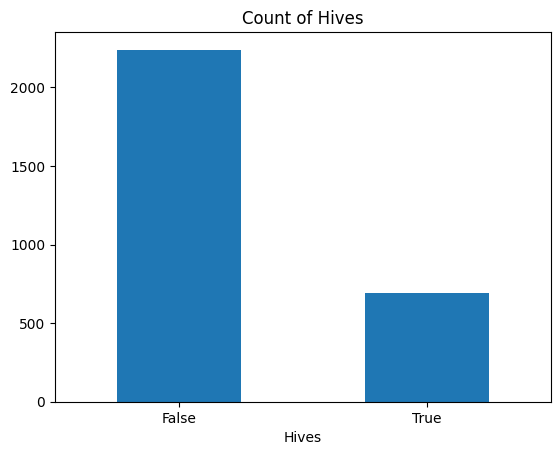

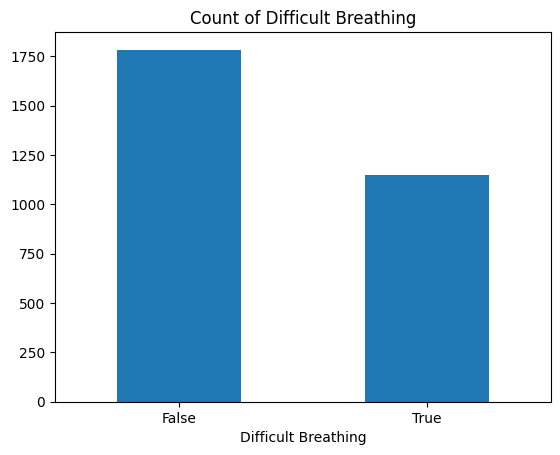

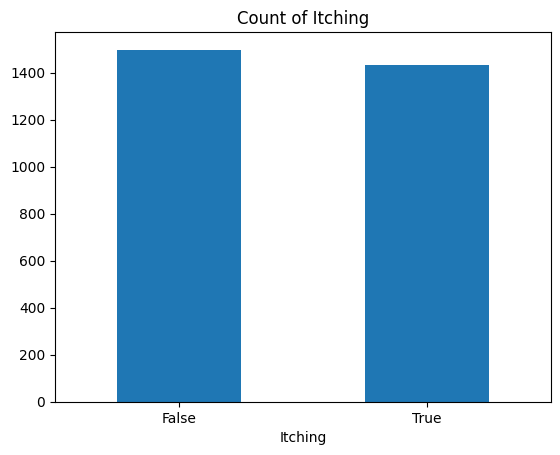

In [25]:
#plotting barplot for count and side effects
for col in ['Hives', 'Difficult Breathing', 'Itching']:
    df[col].value_counts().plot(kind='bar', title=f'Count of {col}')
    plt.xticks([0, 1], ['False', 'True'], rotation=0)
    plt.show()


In [26]:
#link side effects and drug classes using apriori
df['side_effects_list'] = df['side_effects'].apply(extract_side_effects)
df['drug_classes_list'] = df['drug_classes'].apply(extract_drug_classes)


In [27]:
df['combined_items'] = df['side_effects_list'] + df['drug_classes_list']

In [28]:
mlb = MultiLabelBinarizer()
one_hot = pd.DataFrame(mlb.fit_transform(df['combined_items']), columns=mlb.classes_)
one_hot = one_hot.astype(bool)  # Make it boolean for faster Apriori


In [ ]:
#run apriori
frequent_itemsets = fpgrowth(one_hot, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)


In [ ]:
#filter for rules where one is side effects and other is drug classes
side_effect_terms = set(side_effect_counts.index)
drug_class_terms = set(drug_classes_counts.index)

In [33]:
def is_side_effect(term):
    return term in side_effect_terms

def is_drug_class(term):
    return term in drug_class_terms

In [34]:
rules_filtered = rules[
    rules.apply(lambda row: 
        (any(is_side_effect(i) for i in row['antecedents']) and any(is_drug_class(i) for i in row['consequents'])) or
        (any(is_drug_class(i) for i in row['antecedents']) and any(is_side_effect(i) for i in row['consequents'])),
        axis=1
    )
]

In [ ]:
#save apriori results
rules_filtered.to_csv("apriori_sideeffects_drugclasses.csv", index=False)
print(f"\nApriori rules saved to apriori_sideeffects_drugclasses.csv — {len(rules_filtered)} rules found.")


Apriori rules saved to apriori_sideeffects_drugclasses.csv — 2 rules found.
